In [1]:
import os
import sys
import json
import time
import requests

from dotenv import load_dotenv

def setup_env():
    
    env_path = os.path.join(os.getcwd(), '../.env')

    if os.path.exists(env_path):
        load_dotenv(dotenv_path=env_path)
        
        print(f"Loaded environment variables from: \033[94m{env_path}\033[0m")
    else:
            print("\033[91mError: .env file not found. Please create one with your OPENAI_API_KEY.\033[0m")
            sys.exit(1)


In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0, streaming=True)

In [3]:
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI

def analyze_question(state): # 사용자 질문을 분석하여 코드 질문인지 일반 질문인지 분류
    
    llm = ChatOpenAI()
    
    prompt = PromptTemplate.from_template("""
        당신은 사용자 질문이 기술적인 코드 관련 질문인지 일반적인 질문인지 정의해야 하는 에이전트입니다.
        Question : {input}
        질문을 분석하세요. 질문이 기술적 개발에 관한 것이라면 "code"라고 답변하고, 그렇지 않다면 "general"이라고 답변하세요".
        당신의 답변 (code/general) :
        """
    )
    
    chain = prompt | llm
    
    response = chain.invoke({"input": state["input"]})
    
    decision = response.content.strip().lower()
    
    return {"decision": decision, "input": state["input"]}

def code_question(state): # 코드 질문에 대해 단계별로 자세히 답변 생성
    
    llm = ChatOpenAI()
    
    prompt = PromptTemplate.from_template(
        "당신은 소프트웨어 엔지니어입니다. 이 질문에 대해 단계별로 자세히 답변하세요 : {input}"
    )
    
    chain = prompt | llm
    
    response = chain.invoke({"input": state["input"]})
    
    return {"output": response}

def general_question(state): # 일반 질문에 대해 간결하고 일반적인 답변 생성
    
    llm = ChatOpenAI()
    
    prompt = PromptTemplate.from_template(
        "질문에 대해 일반적이고 간결하게 답변하세요: {input}"
    )
    
    chain = prompt | llm
    
    response = chain.invoke({"input": state["input"]})
    
    return {"output": response}

In [ ]:
from langgraph.graph import StateGraph, END

from typing import Annotated, TypedDict

class AgentState(TypedDict):
    input: str
    output: str
    decision: str # 질문의 유형 ("코드 질문" 혹은 "일반 질문").

workflow = StateGraph(AgentState) # "상태 기반" 워크플로우 정의

workflow.add_node("analyze", analyze_question)

workflow.add_node("code_agent", code_question)

workflow.add_node("generic_agent", general_question)

workflow.add_conditional_edges(
    
    "analyze",
    
    lambda x: x["decision"], # "analyze" 단계에서 decision 값에 따라 다음 상태로 전이
    
    {
        "code": "code_agent",
        "general": "generic_agent"
    }
    
)

workflow.set_entry_point("analyze") # 워크플로우의 시작 노드를 "analyze"로 설정

workflow.add_edge("code_agent", END) # code_agent 단계가 완료되면 워크플로우 종료

workflow.add_edge("generic_agent", END)

graph = workflow.compile()

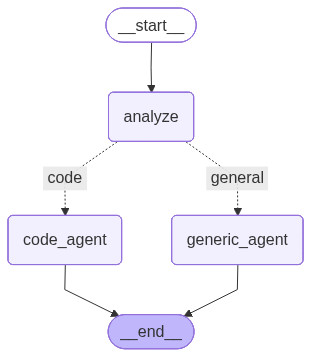

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [6]:
graph.invoke({"input" : "프롬프트란?"})

{'input': '프롬프트란?',
 'output': AIMessage(content='프롬프트는 컴퓨터 시스템에서 사용자로부터 명령을 입력받을 수 있도록 하는 화면 또는 창을 말합니다. 사용자는 프롬프트에 명령어를 입력하여 컴퓨터에게 작업을 요청할 수 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 39, 'total_tokens': 131, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Cfc34ydvUZvm2OGcq3P7d3WK0AQUw', 'finish_reason': 'stop', 'logprobs': None}, id='run-7ad1efc9-5acf-49d9-8d7f-dd344edf7389-0', usage_metadata={'input_tokens': 39, 'output_tokens': 92, 'total_tokens': 131, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 'decision': 'general'}

In [7]:
graph.invoke({"input" : "숫자 입력을 요청하고, 숫자가 아닌 경우 '잘못된 입력'이라는 메시지를 출력하는 코드를 작성해주세요."})

{'input': "숫자 입력을 요청하고, 숫자가 아닌 경우 '잘못된 입력'이라는 메시지를 출력하는 코드를 작성해주세요.",
 'output': AIMessage(content='Sure! 아래는 Python으로 작성된 코드입니다.\n\n```python\nwhile True:\n    try:\n        number = input("숫자를 입력하세요: ")\n        # 입력이 숫자인지 확인\n        float_number = float(number)\n        # 숫자인 경우\n        print(f"입력한 숫자는 {float_number}입니다.")\n        break\n    except ValueError:\n        # 숫자가 아닌 경우\n        print("잘못된 입력입니다. 숫자를 입력해주세요.")\n```\n\n이 코드는 사용자로부터 숫자를 입력받고, 이 입력이 숫자인지 확인합니다. 만약 숫자가 아니라면 ValueError가 발생하여 "잘못된 입력입니다. 숫자를 입력해주세요."라는 메시지를 출력하고, 다시 숫자를 입력하도록 요청합니다. 입력이 숫자일 경우 해당 숫자를 출력하고 반복문을 종료합니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 214, 'prompt_tokens': 91, 'total_tokens': 305, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_finger